*founder: Dirk Derichsweiler, Contributors: Vincent Charbonnier and Isabelle Steinhauser, September 2023*
# Retail End2End Demo

**tested with EZUA 1.2 - Python 3 Kernel - gcr.io/mapr-252711/kubeflow/notebooks/jupyter-tensorflow-full:ezaf-fy23-q4-sp4-r9**

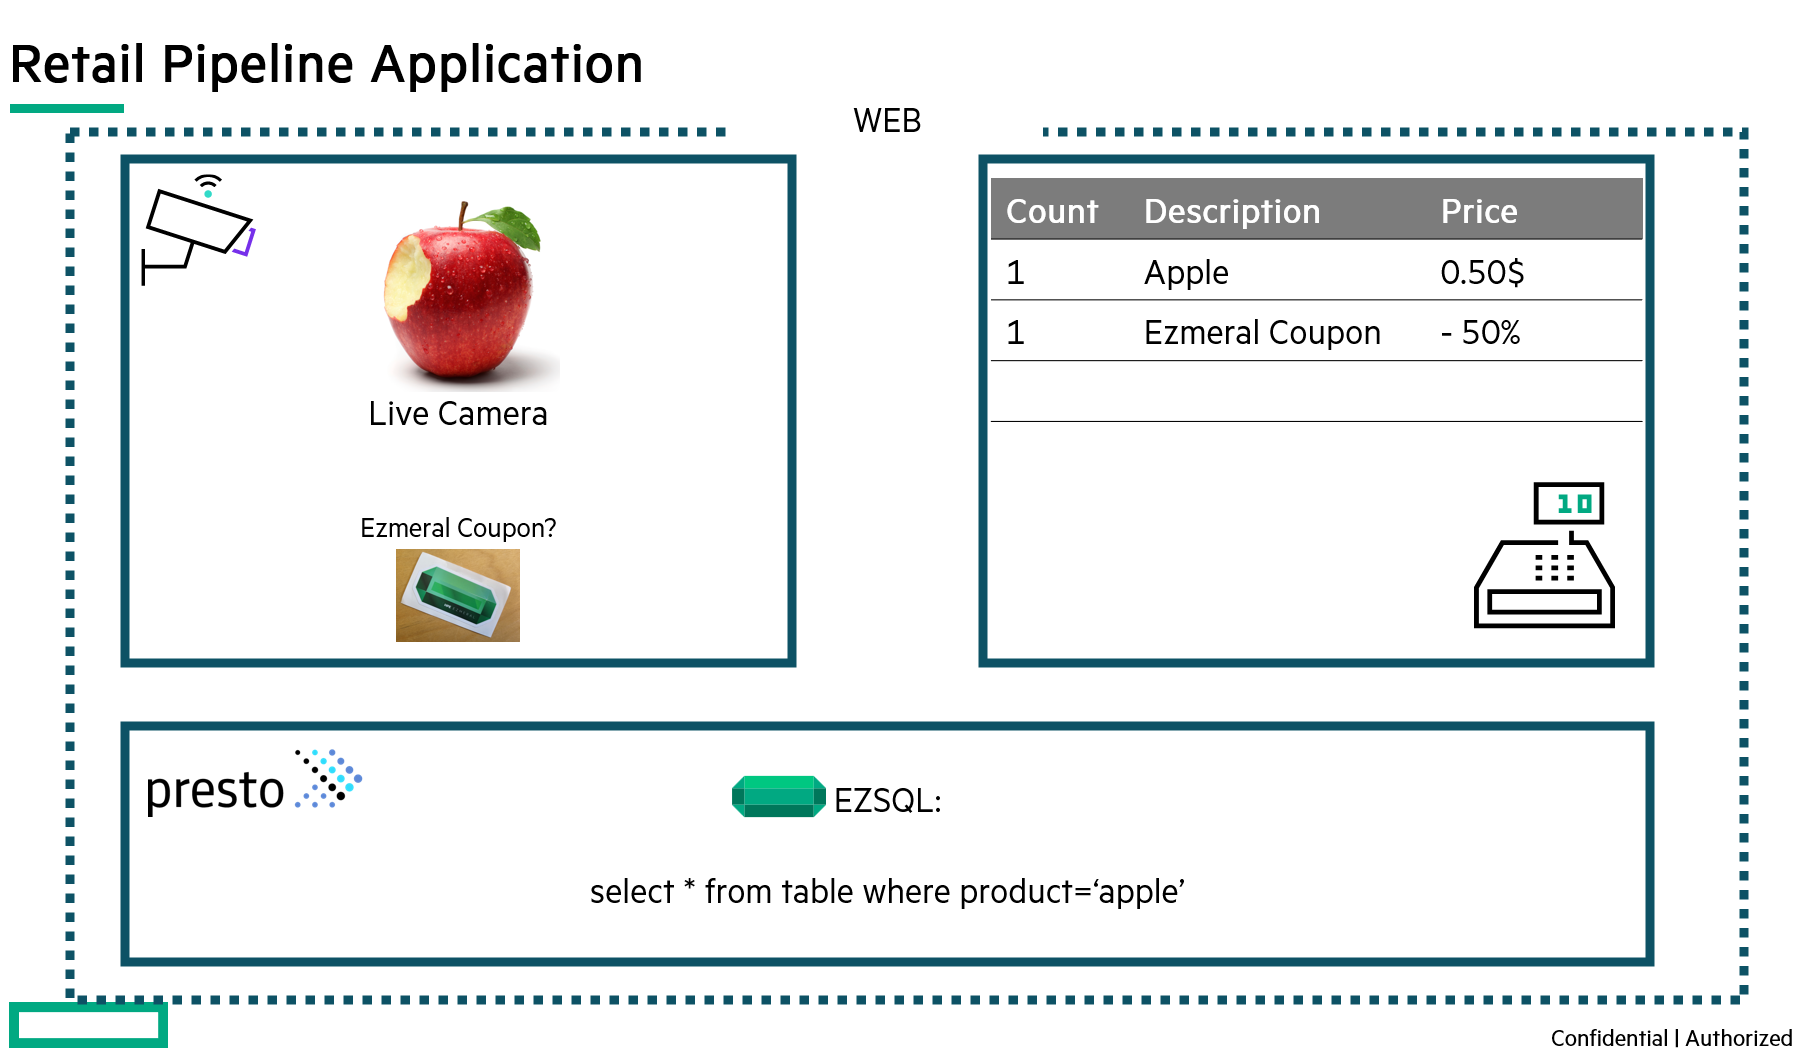

<h1>Table of contents</h1>
 

<ul>
<li><a href="#1"><strong>1. Loading and preprocessing</strong></a>
</ul>
    
<ul>
<li><a href="#2"><strong>2. Load the Images with a generator and Data Augmentation</strong></a>
</ul>

<ul>
<li><a href="#3"><strong>3. Train the model</strong></a>
</ul>

<ul>
<li><a href="#4"><strong>4. Visualize the result</strong></a>
</ul>

<ul>
<li><a href="#5"><strong>5. Class activation heatmap for image classification</strong></a>
</ul>

<ul>
<li><a href="#6"><strong>6. Deploy the model</strong></a>
</ul>





# 0. Prerequisites

In [1]:
import os
# Define the number of epochs to train the model
param_epoch = 30

# Define the batch size to use for training and validation
param_batch_size = 32

# Define the number of epochs to wait before early stopping if the validation loss does not improve
param_patience = 4

# adapt to your EZUA Domain name
EZAF_ENV = "ezua12.ezmeral.demo.local"

# here you can switch between CTC and Fruit
DC = "fruit"

if DC == "ctc":
    path = '/mnt/shared/data/data/ctc/'
    #define all the varibles here
    experiment_name = "ctc-demo-dirk"
    model_name = "ctc-demo-dirk"
    artifact_path = "ctc-model-dirk"
elif DC == "fruit":
    path = '/mnt/shared/data/data/fruits/'
    #define all the varibles here
    experiment_name = "end2end-demo-dirk"
    model_name = "end2end-demo-dirk"
    artifact_path = "model-dirk"
else:
    path = '/mnt/shared/data/data/old/'
    #define all the varibles here
    experiment_name = "end2end-demo-dirk-old"
    model_name = "end2end-demo-dirk-old"
    artifact_path = "old-model-dirk"

In [2]:
dirExist = os.path.exists(path)

if dirExist:
    print()
    print('The following config will be used:')
    print()
    print('experiment_name: ' + experiment_name)
    print('model_name: ' + model_name)
    print('artifact_path: ' + artifact_path)
    print()
else:
    print("Do not run this notebook further, dataset is missing...")


The following config will be used:

experiment_name: end2end-demo-dirk
model_name: end2end-demo-dirk
artifact_path: model-dirk



In [3]:
import importlib
import subprocess
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import mlflow
import mlflow.tensorflow
import mlflow.keras
import os
import urllib3
import time
import requests
import json

2023-11-30 21:05:20.778702: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 21:05:20.781773: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-30 21:05:20.829783: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-30 21:05:20.831613: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 21:05:21.609406: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [4]:
# Install missing packages
# Check if mlflow is installed
try:
    importlib.import_module('mlflow')
except ImportError:
    # If mlflow is not installed, install it with pip
    subprocess.check_call(["pip", "install", "mlflow"])
# Check if kserve is installed
try:
    importlib.import_module('kserve')
except ImportError:
    # If kserve is not installed, install it with pip
    subprocess.check_call(["pip", "install", "kserve"])

### 1. Loading and preprocessing<a class="anchor" id="1"></a><a class="anchor" id="1"></a>

In [15]:
# Create a Path object for the training directory and get a list of all .jpg files in the directory
train_dir = Path(path + 'train')
train_filepaths = [p for p in train_dir.glob('**/*.jpg') if not p.name.startswith('.')] # ignore .ipynb files and directories

# Create a Path object for the testing directory and get a list of all .jpg files in the directory
test_dir = Path(path + 'test')
test_filepaths = [p for p in test_dir.glob('**/*.jpg') if not p.name.startswith('.')]

# Create a Path object for the validation directory and get a list of all .jpg files in the directory
val_dir = Path(path + 'validation')
val_filepaths = [p for p in val_dir.glob('**/*.jpg') if not p.name.startswith('.')]

# Define a function to create a DataFrame with filepaths and labels for a given list of filepaths
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    # Get the labels from the filepath by splitting on the directory separator and taking the second-to-last element
    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath)) \
              if not str(filepath[i]).split("/")[-2].startswith('.')]


    # Convert the list of filepaths to a pandas Series object
    filepath = pd.Series(filepath, name='Filepath',dtype=str)

    # Convert the list of labels to a pandas Series object
    labels = pd.Series(labels, name='Label',dtype=str)

    # Concatenate the filepaths and labels into a DataFrame
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset the index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

# Call the proc_img function on the training filepaths to create a DataFrame for training
train_df = proc_img(train_filepaths)
train_df.dropna(inplace=True)

# Call the proc_img function on the testing filepaths to create a DataFrame for testing
test_df = proc_img(test_filepaths)
test_df.dropna(inplace=True)

# Call the proc_img function on the validation filepaths to create a DataFrame for validation
val_df = proc_img(val_filepaths)
val_df.dropna(inplace=True)

if {len(train_df.Label.unique())} != {len(test_df.Label.unique())} != {len(val_df.Label.unique())}:
    print('incorrect amount of Labels, please do not continue...')


print()
print('#### Training set ####')
print()
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')
print()
print('#### Test set ####')
print()
print('-- Test set --\n')
print(f'Number of pictures: {test_df.shape[0]}\n')
print(f'Number of different labels: {len(test_df.Label.unique())}\n')
print(f'Labels: {test_df.Label.unique()}')
print()
print('#### Validation set ####')
print()
print('-- Validate set --\n')
print(f'Number of pictures: {val_df.shape[0]}\n')
print(f'Number of different labels: {len(val_df.Label.unique())}\n')
print(f'Labels: {val_df.Label.unique()}')



#### Training set ####

-- Training set --

Number of pictures: 3547

Number of different labels: 37

Labels: ['pear' 'sweetpotato' 'ezmeral' 'beetroot' 'orange' 'lettuce' 'corn'
 'apple' 'cauliflower' 'cabbage' 'potato' 'paprika' 'lemon' 'mango'
 'raddish' 'onion' 'carrot' 'banana' 'pomegranate' 'ginger' 'watermelon'
 'garlic' 'grapes' 'capsicum' 'soy beans' 'cucumber' 'chilli pepper'
 'bell pepper' 'peas' 'eggplant' 'sweetcorn' 'pineapple' 'jalepeno' 'kiwi'
 'tomato' 'spinach' 'turnip']

#### Test set ####

-- Test set --

Number of pictures: 348

Number of different labels: 37

Labels: ['eggplant' 'cauliflower' 'ginger' 'watermelon' 'cucumber' 'potato'
 'beetroot' 'pineapple' 'pear' 'bell pepper' 'pomegranate' 'orange'
 'turnip' 'lettuce' 'ezmeral' 'tomato' 'kiwi' 'peas' 'corn' 'sweetcorn'
 'onion' 'sweetpotato' 'lemon' 'grapes' 'carrot' 'capsicum' 'soy beans'
 'garlic' 'mango' 'chilli pepper' 'raddish' 'spinach' 'jalepeno' 'apple'
 'banana' 'cabbage' 'paprika']

#### Validation se

In [16]:
# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

,Filepath,Label
0,/mnt/shared/data/data/fruits/train/pear/Image_...,pear
1,/mnt/shared/data/data/fruits/train/sweetpotato...,sweetpotato
2,/mnt/shared/data/data/fruits/train/ezmeral/202...,ezmeral
3,/mnt/shared/data/data/fruits/train/beetroot/Im...,beetroot
4,/mnt/shared/data/data/fruits/train/orange/Imag...,orange


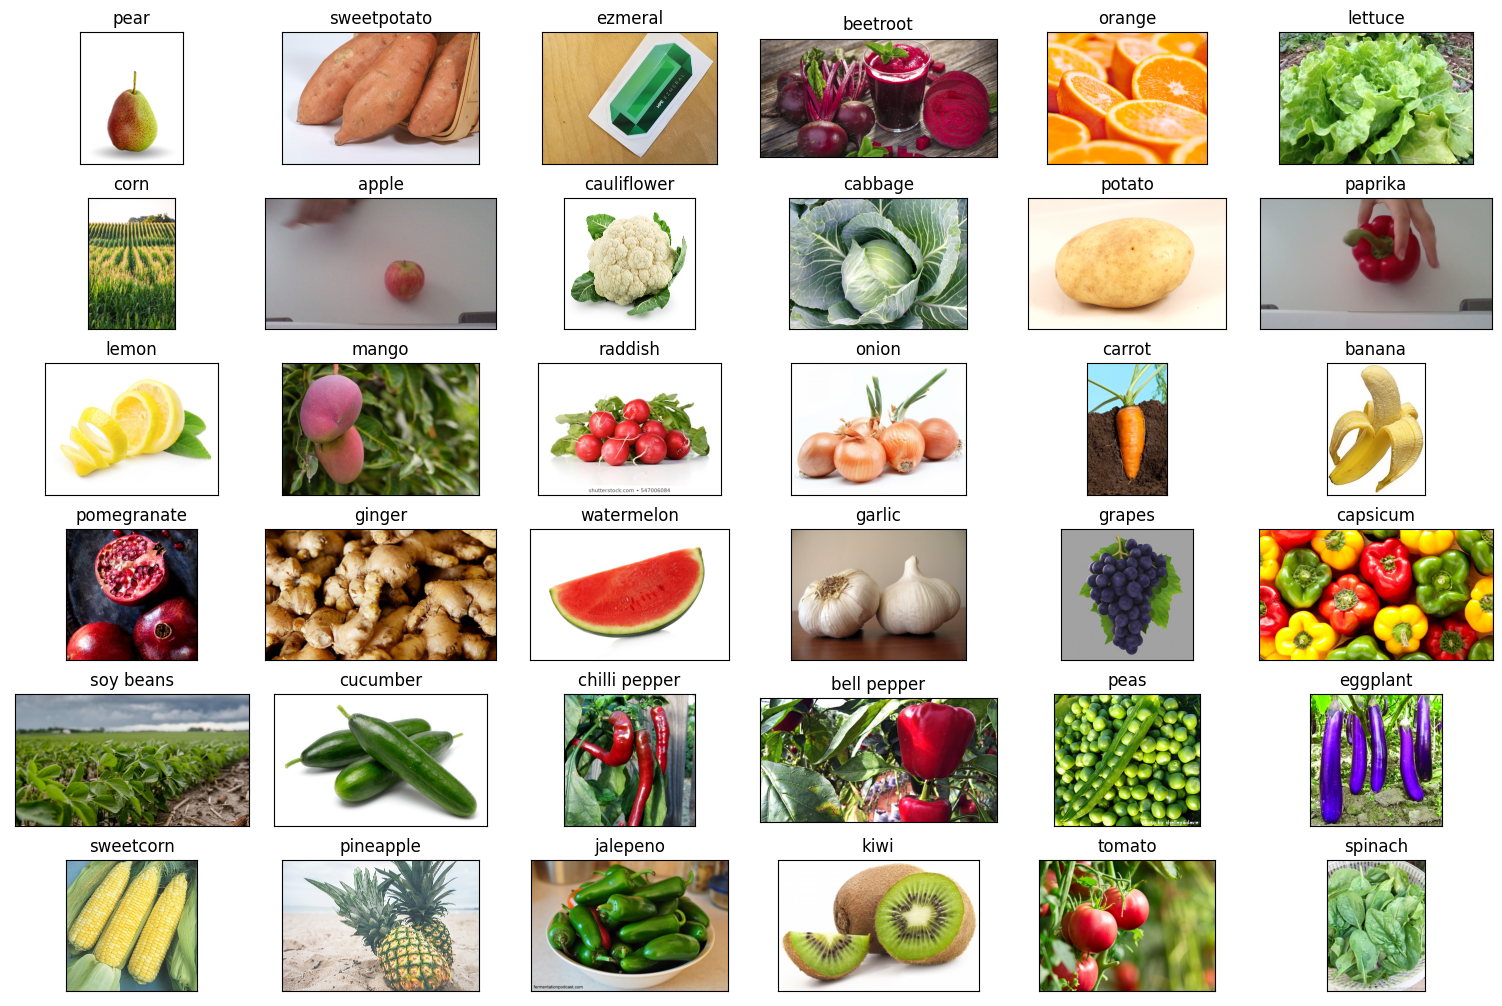

In [17]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < len(df_unique):
        ax.imshow(plt.imread(df_unique.iloc[i]['Filepath']))
        ax.set_title(df_unique.iloc[i]['Label'], fontsize = 12)
plt.tight_layout(pad=0.5)
#plt.show()

# 2. Load the Images with a generator and Data Augmentation<a class="anchor" id="2"></a>

In [18]:
# Create an image data generator for preprocessing train images using MobileNetV2
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Generate a flow of images and labels from a Pandas dataframe for training
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df, # Use the specified Pandas dataframe
    x_col='Filepath', # Use the 'Filepath' column as the input (x) data
    y_col='Label', # Use the 'Label' column as the output (y) data
    target_size=(224, 224), # Resize the images to the specified dimensions
    color_mode='rgb', # Use RGB color mode
    class_mode='categorical', # Use categorical classification
    batch_size=32, # Generate batches of 32 images at a time
    shuffle=True, # Shuffle the order of the images
    seed=0, # Use a fixed seed for reproducibility
    rotation_range=30, # Randomly rotate images up to 30 degrees
    zoom_range=0.15, # Randomly zoom images up to 15%
    width_shift_range=0.2, # Randomly shift images horizontally up to 20%
    height_shift_range=0.2, # Randomly shift images vertically up to 20%
    shear_range=0.15, # Randomly apply shearing transformations to images
    horizontal_flip=True, # Randomly flip images horizontally
    fill_mode="nearest", # Use the nearest pixel to fill any empty spaces created by image transformations
)
# Create an image data generator for preprocessing validation images using MobileNetV2
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Generate a flow of images and labels from a Pandas dataframe for validation
val_images = val_generator.flow_from_dataframe(
    dataframe=val_df, # Use the specified Pandas dataframe
    x_col='Filepath', # Use the 'Filepath' column as the input (x) data
    y_col='Label', # Use the 'Label' column as the output (y) data
    target_size=(224, 224), # Resize the images to the specified dimensions
    color_mode='rgb', # Use RGB color mode
    class_mode='categorical', # Use categorical classification
    batch_size=32, # Generate batches of 32 images at a time
    shuffle=True, # Shuffle the order of the images
    seed=0, # Use a fixed seed for reproducibility
    rotation_range=30, # Randomly rotate images up to 30 degrees
    zoom_range=0.15, # Randomly zoom images up to 15%
    width_shift_range=0.2, # Randomly shift images horizontally up to 20%
    height_shift_range=0.2, # Randomly shift images vertically up to 20%
    shear_range=0.15, # Randomly apply shearing transformations to images
    horizontal_flip=True, # Randomly flip images horizontally
    fill_mode="nearest" # Use the nearest pixel to fill any empty spaces created by image transformations
)
# Create an image data generator for preprocessing test images using MobileNetV2
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Generate a flow of images and labels from a Pandas dataframe
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df, # Use the specified Pandas dataframe
    x_col='Filepath', # Use the 'Filepath' column as the input (x) data
    y_col='Label', # Use the 'Label' column as the output (y) data
    target_size=(224, 224), # Resize the images to the specified dimensions
    color_mode='rgb', # Use RGB color mode
    class_mode='categorical', # Use categorical classification
    batch_size=32, # Generate batches of 32 images at a time
    shuffle=False # Do not shuffle the order of the images
)

Found 3547 validated image filenames belonging to 37 classes.
Found 351 validated image filenames belonging to 37 classes.
Found 348 validated image filenames belonging to 37 classes.


In [19]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

# 3. Train the model<a class="anchor" id="3"></a>

### 3.1 MLflow config setup 

In [20]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)


token_url = f"https://keycloak.{EZAF_ENV}/realms/UA/protocol/openid-connect/token"

# Get username from Unix
output = subprocess.check_output("id | awk '{print $1}' | cut -d '(' -f 2 | cut -d ')' -f 1", shell=True)
user = output.decode("utf-8").strip()
# Check if the username is 'root'
if user == 'root':
    # Ask for the user's name if the username is 'root'
    user = input("Please enter your name: ")

data = {
    "username" : user,
    "password" : "Hpepoc@123",
    "grant_type" : "password",
    "client_id" : "ua-grant"
}

token_responce = requests.post(token_url, data=data, allow_redirects=True, verify=False)

token = token_responce.json()["access_token"]

def set_exp(exp_name):
    """
    This function is used to register an experiment in mlflow tracking service.
    The name of the experiment provided by the user will be set in mlflow.
    """
    try:
        usr = user
        os.environ['MLFLOW_TRACKING_INSECURE_TLS'] = 'true'
        os.environ["AWS_ACCESS_KEY_ID"] = f"minioadmin"
        os.environ["AWS_SECRET_ACCESS_KEY"] = f"minioadmin"
        os.environ["MLFLOW_S3_ENDPOINT_URL"] = f"https://objectstore-zone1-svc.dataplatform.svc.cluster.local:9000" #ADAPT to your EZUA env
        os.environ['MLFLOW_ARTIFACT_ROOT'] = f"s3://mlflow"
        os.environ['MLFLOW_S3_IGNORE_TLS'] = f"true"
        os.environ['MLFLOW_TRACKING_TOKEN'] = token
        mlflow.set_tracking_uri(f"https://mlflow.{EZAF_ENV}")
        mlflow.set_experiment(exp_name)
        mlflow.set_tag('mlflow.user', usr)
    except Exception as e:
        print("Failed to set user " + str(usr))
        print(e)

In [21]:
# Set up an experiment with set_exp from ezmllib.mlflow
# experiment_name = 'demo-fruit-veg-exp'
set_exp(experiment_name)

In [ ]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Get the input layer of the pretrained model
inputs = pretrained_model.input

# Add a new dense layer with 128 units and ReLU activation to the output of the pretrained model
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)

# Add another new dense layer with 128 units and ReLU activation to the previous layer
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Get the number of unique labels in the training set
labels = len(train_df.Label.unique())

# Add a new dense layer with softmax activation to the previous layer to get the output of the new model
outputs = tf.keras.layers.Dense(labels, activation='softmax')(x)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Start a new MLflow run
if mlflow.active_run():
    mlflow.end_run()
    
# Start a new MLflow run
with mlflow.start_run():
    
    # Log the model architecture as a Keras summary
    mlflow.autolog()
    
    # Log the hyperparameters
    mlflow.log_param("batch_size", param_batch_size)
    mlflow.log_param("epochs", param_epoch)
    mlflow.log_param("patience", param_patience)
    
    # Get the full model path
    run_id = mlflow.active_run().info.run_id
    artifact_uri = mlflow.get_artifact_uri(run_id)
    artifact_path = "model"
    test_uri = "s3://mlflow/3/{run_id}/artifacts/{artifact_path}".format(run_id=run_id, artifact_path=artifact_path)

    # Train the model with the specified hyperparameters and callbacks
    history = model.fit(
        train_images,
        validation_data=val_images,
        batch_size=param_batch_size,
        epochs=param_epoch,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=param_patience,
                restore_best_weights=True
            )
        ]
    )

    # Save the model in TensorFlow Serving format
    tf.saved_model.save(model, "tf_serving_model/1")

    # Log the saved model as an artifact
    mlflow.log_artifact("tf_serving_model")
    
    # Log the final metrics
    mlflow.log_metric("train_loss", history.history["loss"][-1])
    mlflow.log_metric("train_accuracy", history.history["accuracy"][-1])
    mlflow.log_metric("val_loss", history.history["val_loss"][-1])
    mlflow.log_metric("val_accuracy", history.history["val_accuracy"][-1])

2023/11/30 21:12:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2023/11/30 21:12:26 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.
2023/11/30 21:12:26 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.
Found credentials in environment variables.


Epoch 1/30
111/111 [==============================] - 145s 1s/step - loss: 1.5460 - accuracy: 0.5892 - val_loss: 0.4259 - val_accuracy: 0.8917
Epoch 2/30
111/111 [==============================] - 136s 1s/step - loss: 0.5615 - accuracy: 0.8311 - val_loss: 0.2449 - val_accuracy: 0.9345
Epoch 3/30
 11/111 [=>............................] - ETA: 2:00 - loss: 0.3511 - accuracy: 0.9091

In [ ]:
model.save(path + '/'+ DC +'-model.h5')

## Fastpath - just load the model :-)

In [ ]:
from tensorflow import keras
model = keras.models.load_model(path + '/'+ DC +'-model.h5')
#model.summary()

In [ ]:
#Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# 4. Visualize the result<a class="anchor" id="4"></a>

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

In [ ]:
labels.items()

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix,
            cmap="viridis",
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# 5. Class activation heatmap for image classification<a class="anchor" id="5"></a>
### Grad-CAM class activation visualization
*Code adapted from keras.io*

In [ ]:
import matplotlib.cm as cm

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].activation = None


In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

## Validate Accuracy by predicting on the test dataset

In [ ]:
import numpy as np
def predict(location):
    from tensorflow.keras.preprocessing.image import load_img,img_to_array
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [ ]:
from IPython.display import display
from PIL import Image

location = '/mnt/shared/end2end/demo_folder/retail-demo/apfel.jpeg'

img = predict(location)
img

In [ ]:
display(Image.open(location))

# 6. Register the Model<a class="anchor" id="6"></a>

In [ ]:
#urllib3.disable_warnings()
# Set up an experiment with set_exp from ezmllib.mlflow
#experiment_name = 'demo-fruit-veg-exp'
#set_exp(experiment_name)

In [ ]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities.model_registry.model_version_status import ModelVersionStatus

#model_name = "demo-fruit-veg-model"
#artifact_path = "model"
model_uri = "runs:/{run_id}/{artifact_path}".format(run_id=run_id, artifact_path=artifact_path)
model_details = mlflow.register_model(model_uri=model_uri, name=model_name)

# Wait until the model is ready
def wait_until_ready(model_name, model_version):
    client = MlflowClient()
    for _ in range(10):
        model_version_details = client.get_model_version(
          name=model_name,
          version=model_version,
        )
        status = ModelVersionStatus.from_string(model_version_details.status)
        print("Model status: %s" % ModelVersionStatus.to_string(status))
        if status == ModelVersionStatus.READY:
            break
        time.sleep(1)
        client.update_registered_model(
            name=model_details.name,
            description="Fruit & Vegetables Cashierless Store"
        )

wait_until_ready(model_details.name, model_details.version)

## Transition our latest model version to Staging

In [ ]:
import mlflow
import mlflow.tensorflow
from mlflow.tracking.client import MlflowClient

client = MlflowClient()

# Model Description
#model_name = "demo-fruit-veg-model"
client.update_registered_model(
  name=model_name,
  description="Model Registered"
)

# Transition the desired model version to production stage
latest_versions = client.get_latest_versions(name=model_name, stages=["None"])
latest_version = latest_versions[0]

# Model Version Description
client.update_model_version(
  name=model_name,
  version=latest_version.version,
  description="Added Ezmeral logo for discounts"
)

client.transition_model_version_stage(
  name=model_name,
  version=latest_version.version,
  stage='staging',
)

## Test Prediction from S3

In [ ]:
import mlflow
# Retrieve the model version information
model_version = client.get_model_version(name=model_name, version=latest_version.version)

# Get the source URI or location of the model version
logged_model = model_version.source

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [ ]:
def predict(image):
    # Preprocess the image
    from tensorflow.keras.preprocessing.image import load_img,img_to_array
    image=load_img(location,target_size=(224,224,3))
    #image = image.resize((224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255


    # Make a prediction
    prediction = loaded_model.predict(image)
    prediction = np.argmax(prediction, axis=1)
    prediction = labels[prediction[0]]

    return prediction

In [ ]:
from IPython.display import display
from PIL import Image

location = '/mnt/shared/end2end/demo_folder/retail-demo/apfel.jpeg'

#labels = ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum',
#           'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'ezmeral',
#           'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 
#           'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 
#           'raddish', 'soy beans', 'spinach', 'sweet potato', 'sweetcorn', 'tomato', 'turnip', 'watermelon']

img = predict(location)
img

## Retire old models & Transition our best performing model version to Production

In [ ]:
urllib3.disable_warnings()
# Set up an experiment with set_exp from ezmllib.mlflow
# experiment_name = 'demo-fruit-veg-exp'
set_exp(experiment_name)

# Search for the experiment by name
experiment = client.get_experiment_by_name(experiment_name)

if experiment is not None:
    experiment_id = experiment.experiment_id
    print("Experiment ID:", experiment_id)
else:
    print("Experiment not found.")

In [ ]:
# Get all runs within the experiment
runs = client.search_runs(experiment_ids=[experiment_id])

# Find the run with the best accuracy
best_accuracy = -1
best_run = None
for run in runs:
    if run.data.metrics and "accuracy" in run.data.metrics:
        accuracy = run.data.metrics["accuracy"]
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_run = run

# Display the best run
if best_run:
    print("Best Run ID:", best_run.info.run_id)
    print("Accuracy:", best_accuracy)
else:
    print("No runs found with accuracy metric.")

print("------------------")

In [ ]:
run_id = best_run.info.run_id 

# Search for registered models
registered_models = client.search_registered_models()

# Iterate over registered models to find the ones associated with the run ID
for model in registered_models:
    model_name = model.name
    model_versions = model.latest_versions

    # Iterate over model versions to check if they are associated with the run ID
    for version in model_versions:
        if version.run_id == run_id:
            model_version = version.version
            print("Model Name:", model_name)
            print("Model Version:", model_version)
            print("------------------")

# If no registered models are found for the run ID
if not any(model.latest_versions for model in registered_models):
    print("No registered models found for the run.")


In [ ]:
# Transition model versions to a different stage if their current stage is not "production"
model_versions = client.search_model_versions("")

# Find the model version you want to transition to the "Production" stage (assuming it is the one in "Staging" stage)
for model_version in model_versions:
    if model_version.current_stage == "Staging":
        # Extract the model version number (assuming the version is an integer)
        version_to_transition = int(model_version.version)

        # Transition the specific run to the "production" stage
        client.transition_model_version_stage(
            name=model_name,
            version=version_to_transition,
            stage="Production"  
        )
        print(f"The best run, Run ID: {run_id} and Model: {model_name}, version: {version_to_transition} has been moved to Production")

        # Update Model Version Description
        client.update_model_version(
            name=model_name,
            version=version_to_transition,
            description="Best Accuracy model moved to Production"
        )
        break
else:
    print("No model version found in the 'Staging' stage.")

In [ ]:
# Transition model versions to a different stage if their current stage is not "production"
for mv in model_versions:
    if mv.current_stage != "Production":
        client.transition_model_version_stage(
            name=mv.name,
            version=mv.version,
            stage="Archived"
        )
        print(f"Model: {mv.name}, version: {mv.version} has been moved to Archived")

        # Update Model Version Description
        client.update_model_version(
            name=mv.name,
            version=mv.version,
            description="Model Moved to Archived"
        )

# 7. Model Serving with KServe

In [ ]:
# !kubectl delete inferenceservice end2end-demo-dirk-isvc

In [ ]:
from kubernetes import client 
from kubernetes.client import V1EnvVar
from kubernetes.client.models import V1ObjectMeta
from kserve import KServeClient
from kserve import constants
from kserve import utils
from kserve import V1beta1InferenceService
from kserve import V1beta1InferenceServiceSpec
from kserve import V1beta1PredictorSpec
from kserve import V1beta1TFServingSpec

urllib3.disable_warnings()
# Set up an experiment with set_exp from ezmllib.mlflow
#experiment_name = 'demo-fruit-veg-exp'
#set_exp(experiment_name)

# create an instance of the MlflowClient
client = mlflow.tracking.MlflowClient()

# Get the latest model version in Production
latest_versions = client.get_latest_versions(name=model_name, stages=["Production"])
latest_version = latest_versions[0]

# Get the model uri
model_uri = latest_version.source.replace("model", "tf_serving_model")


isvc_name = experiment_name + "-isvc"

predictor = V1beta1PredictorSpec(
    min_replicas=1,
    service_account_name="kserve-minio-sa",
    tensorflow=(V1beta1TFServingSpec(
                storage_uri=model_uri)
                )
)
print(constants.KSERVE_KIND)
isvc = V1beta1InferenceService(api_version=constants.KSERVE_V1BETA1,
                               kind=constants.KSERVE_KIND,
                               metadata=V1ObjectMeta(
                                    name=isvc_name,
                                    annotations={"sidecar.istio.io/inject": "true"}
                               ),
                               spec=V1beta1InferenceServiceSpec(predictor=predictor))

kserve_client = KServeClient()
kserve_client.create(isvc)
#print(V1beta1InferenceServiceS(pec(predictor=predictor))

In [ ]:
# Check if the ISvc already exists
existing_isvc = kserve_client.get(isvc_name)

if existing_isvc:
    # The ISvc exists, update it with the new configuration
    kserve_client.replace(isvc_name, isvc)
    print(f"InferenceService {isvc_name} updated.")
else:
    # The ISvc doesn't exist, create it
    kserve_client.create(isvc)
    print(f"InferenceService {isvc_name} created.")

# Wait until the ISvc is ready (optional)
kserve_client.wait_isvc_ready(isvc_name)
print(f"InferenceService {isvc_name} is ready.")

# 8. Predictions

In [ ]:
import requests
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_url):
    # Load the image
    response = requests.get(image_url, stream=True)
    image = Image.open(response.raw)
    
    display(image)

    # Resize the image
    image = image.resize((224, 224))

    # Convert the image to a NumPy array
    image = img_to_array(image)

    # Expand the dimensions to match the expected shape (1, 224, 224, 3)
    image = np.expand_dims(image, axis=0)

    # Normalize the image by dividing by 255
    image = image / 255.0

    return image

def format_data(data):
    # Convert the NumPy array to a list
    data_list = data.tolist()
    
    # Format the list as a JSON string
    data_formatted = json.dumps(data_list)
    
    # Create a JSON request string with the formatted data
    json_request = '{{ "instances" : {} }}'.format(data_formatted)
    
    return json_request

In [ ]:
# Specify the image URL here.
image_url = "https://www.kroger.com/product/images/large/front/0000000004062"

preprocessed_image = preprocess_image(image_url)

json_request = format_data(preprocessed_image)

In [ ]:
url = "https://" + experiment_name + "-isvc-predictor-default.demo-user."+ EZAF_ENV
print(url)

In [ ]:
# Specify the prediction URL. If you are runing this notebook outside of Kubernetes cluster, you should set the Cluster IP.
#ADAPT to your EZUA instance
url = "http://{}-predictor-default.{}."+ EZAF_ENV +"/v1/models/{}:predict".format(isvc_name, user, isvc_name)
url = "https://" + experiment_name + "-isvc-predictor-default.demo-user."+ EZAF_ENV
# https://end2end-demo-dirk-isvc-predictor-default.demo-user.ezua12.ezmeral.demo.local
    
print(url)

# Make the POST request
response = requests.post(url, data=json_request, verify=False)

# If the response is in JSON format, you can decode it
if response.headers.get("Content-Type") == "application/json":
    response_data = response.json()
    predictions = response_data['predictions']

    formatted_predictions = [[round(pred, 2) for pred in prediction] for prediction in predictions]

    print("Formatted Predictions:")
    print(formatted_predictions)

In [ ]:
labels.items()

In [ ]:
labels = ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum',
          'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'ezmeral',
          'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 
          'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 
          'raddish', 'soy beans', 'spinach', 'sweet potato', 'sweetcorn', 'tomato', 'turnip', 'watermelon']

type(labels)

#predicted_label_index = np.argmax(formatted_predictions)
#predicted_label = labels[predicted_label_index]

#print("Predicted class label:", predicted_label)

# Todo List <a class="anchor" id="42"></a>

- Distribute training job
- figure out a way to obtain the platform username (not root when running the pipeline)
- Use Katib to select Hyperparameters (and set them for a real purpose)
- Clean this notebook from useless code
- Build a demo story: first we explore and analyze the data then we automize the job with a pipeline
- Something to correct with MLflow: optimize the code by removing useless & repetitive content, make sure there is 1 run done for 1 pipeline, 
- Select the best run to be deployed 
- Variables are defined everywhere, see if it is possible to define them in the beginning and take care of the redundancy but be careful it works with Kubeflow!